# Traffic Sign Recognition

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gtsrb-german-traffic-sign.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing Libraries**

In [83]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

**Labels**

In [58]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Vehicle > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing vehicle > 3.5 tons' }

In [84]:
BASE_DIR  = '/kaggle/input/gtsrb-german-traffic-sign/'
TRAIN_DIR = base_dir + 'Train'
TEST_DIR  = base_dir + 'Test'
TARGET_SIZE = (30,30)
BATCH_SIZE = 32
NUM_CATEGORIES = len(os.listdir(TRAIN_DIR))

**Collecting Training Data**

In [87]:
image_data = []
image_labels = []
for i in range(NUM_CATEGORIES):
    path = TRAIN_DIR + '/' + str(i)
    images = os.listdir(path)
    for image in images:
        image = cv2.imread(path + '/' + image)
        image = Image.fromarray(image,'RGB')
        image = image.resize(TARGET_SIZE)
        image_data.append(np.array(image))
        image_labels.append(i)
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


**Shuffling Indices**

In [88]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

**Train Test Data Splitting**

In [89]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


**Label Encoding**

In [90]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


**Visualizing the dataset**

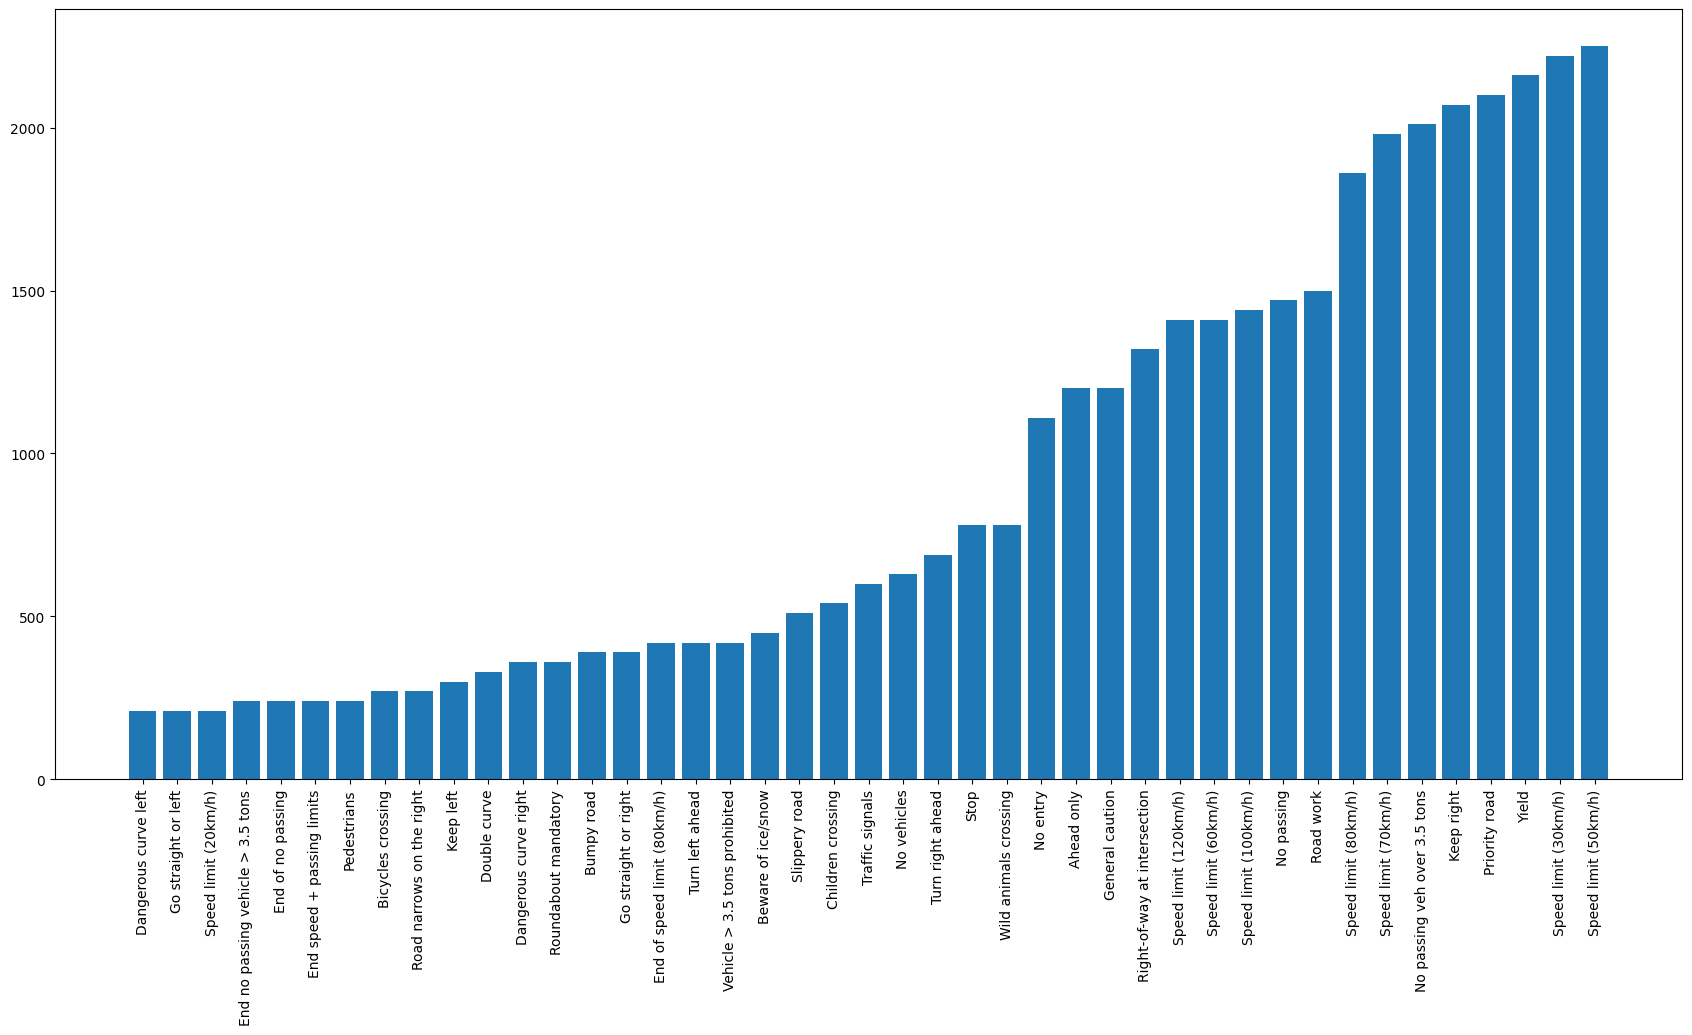

In [61]:
folders = os.listdir(train_dir)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

**Creating a Model**

In [91]:
from keras.layers import Dense, Conv2D, MaxPool2D,Flatten, BatchNormalization, Dropout,Input
from keras.models import Sequential, load_model
from keras.regularizers import l2

In [92]:
model = Sequential([
    Input(shape=(TARGET_SIZE[0],TARGET_SIZE[1],3)),
    #Conv Block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1),
    #Conv Block 2
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1),
    
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(axis=-1),
    Dropout(rate=0.5),
    
    Dense(43, activation='softmax')
])

**Compiling the Model**

In [93]:
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Add the LearningRateScheduler to your callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)

In [94]:
learning_rate = 0.001
epochs = 30

In [95]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate = learning_rate)

In [96]:

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

**Training the model**

In [38]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # You can also monitor 'val_accuracy' if preferred
    patience=5,          # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restores the weights from the best epoch
)


**Data Augmentation**

In [97]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [98]:
history = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),epochs=epochs,validation_data=(X_val, y_val), callbacks=[early_stopping,lr_scheduler])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5020 - loss: 2.0360 - val_accuracy: 0.9713 - val_loss: 0.1014 - learning_rate: 0.0010
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9330 - loss: 0.2160 - val_accuracy: 0.9327 - val_loss: 0.2066 - learning_rate: 0.0010
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9627 - loss: 0.1212 - val_accuracy: 0.9935 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9702 - loss: 0.0956 - val_accuracy: 0.9748 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9739 - loss: 0.0811 - val_accuracy: 0.9934 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9784 - loss: 0.0705 - val_accuracy: 0.9965 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9815 - loss: 0.0594

In [105]:
model.save('/kaggle/working/TrafficRecognitionModel.keras')

**Testing the model**

In [103]:
test = pd.read_csv(BASE_DIR + '/Test.csv')


labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    image = cv2.imread(BASE_DIR + '/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize(TARGET_SIZE)
    data.append(np.array(resize_image))

X_test = np.array(data)
X_test = X_test/255

pred = [np.argmax(x) for x in model.predict(X_test)]

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Data accuracy:  98.78068091844814


**Plotting the model**

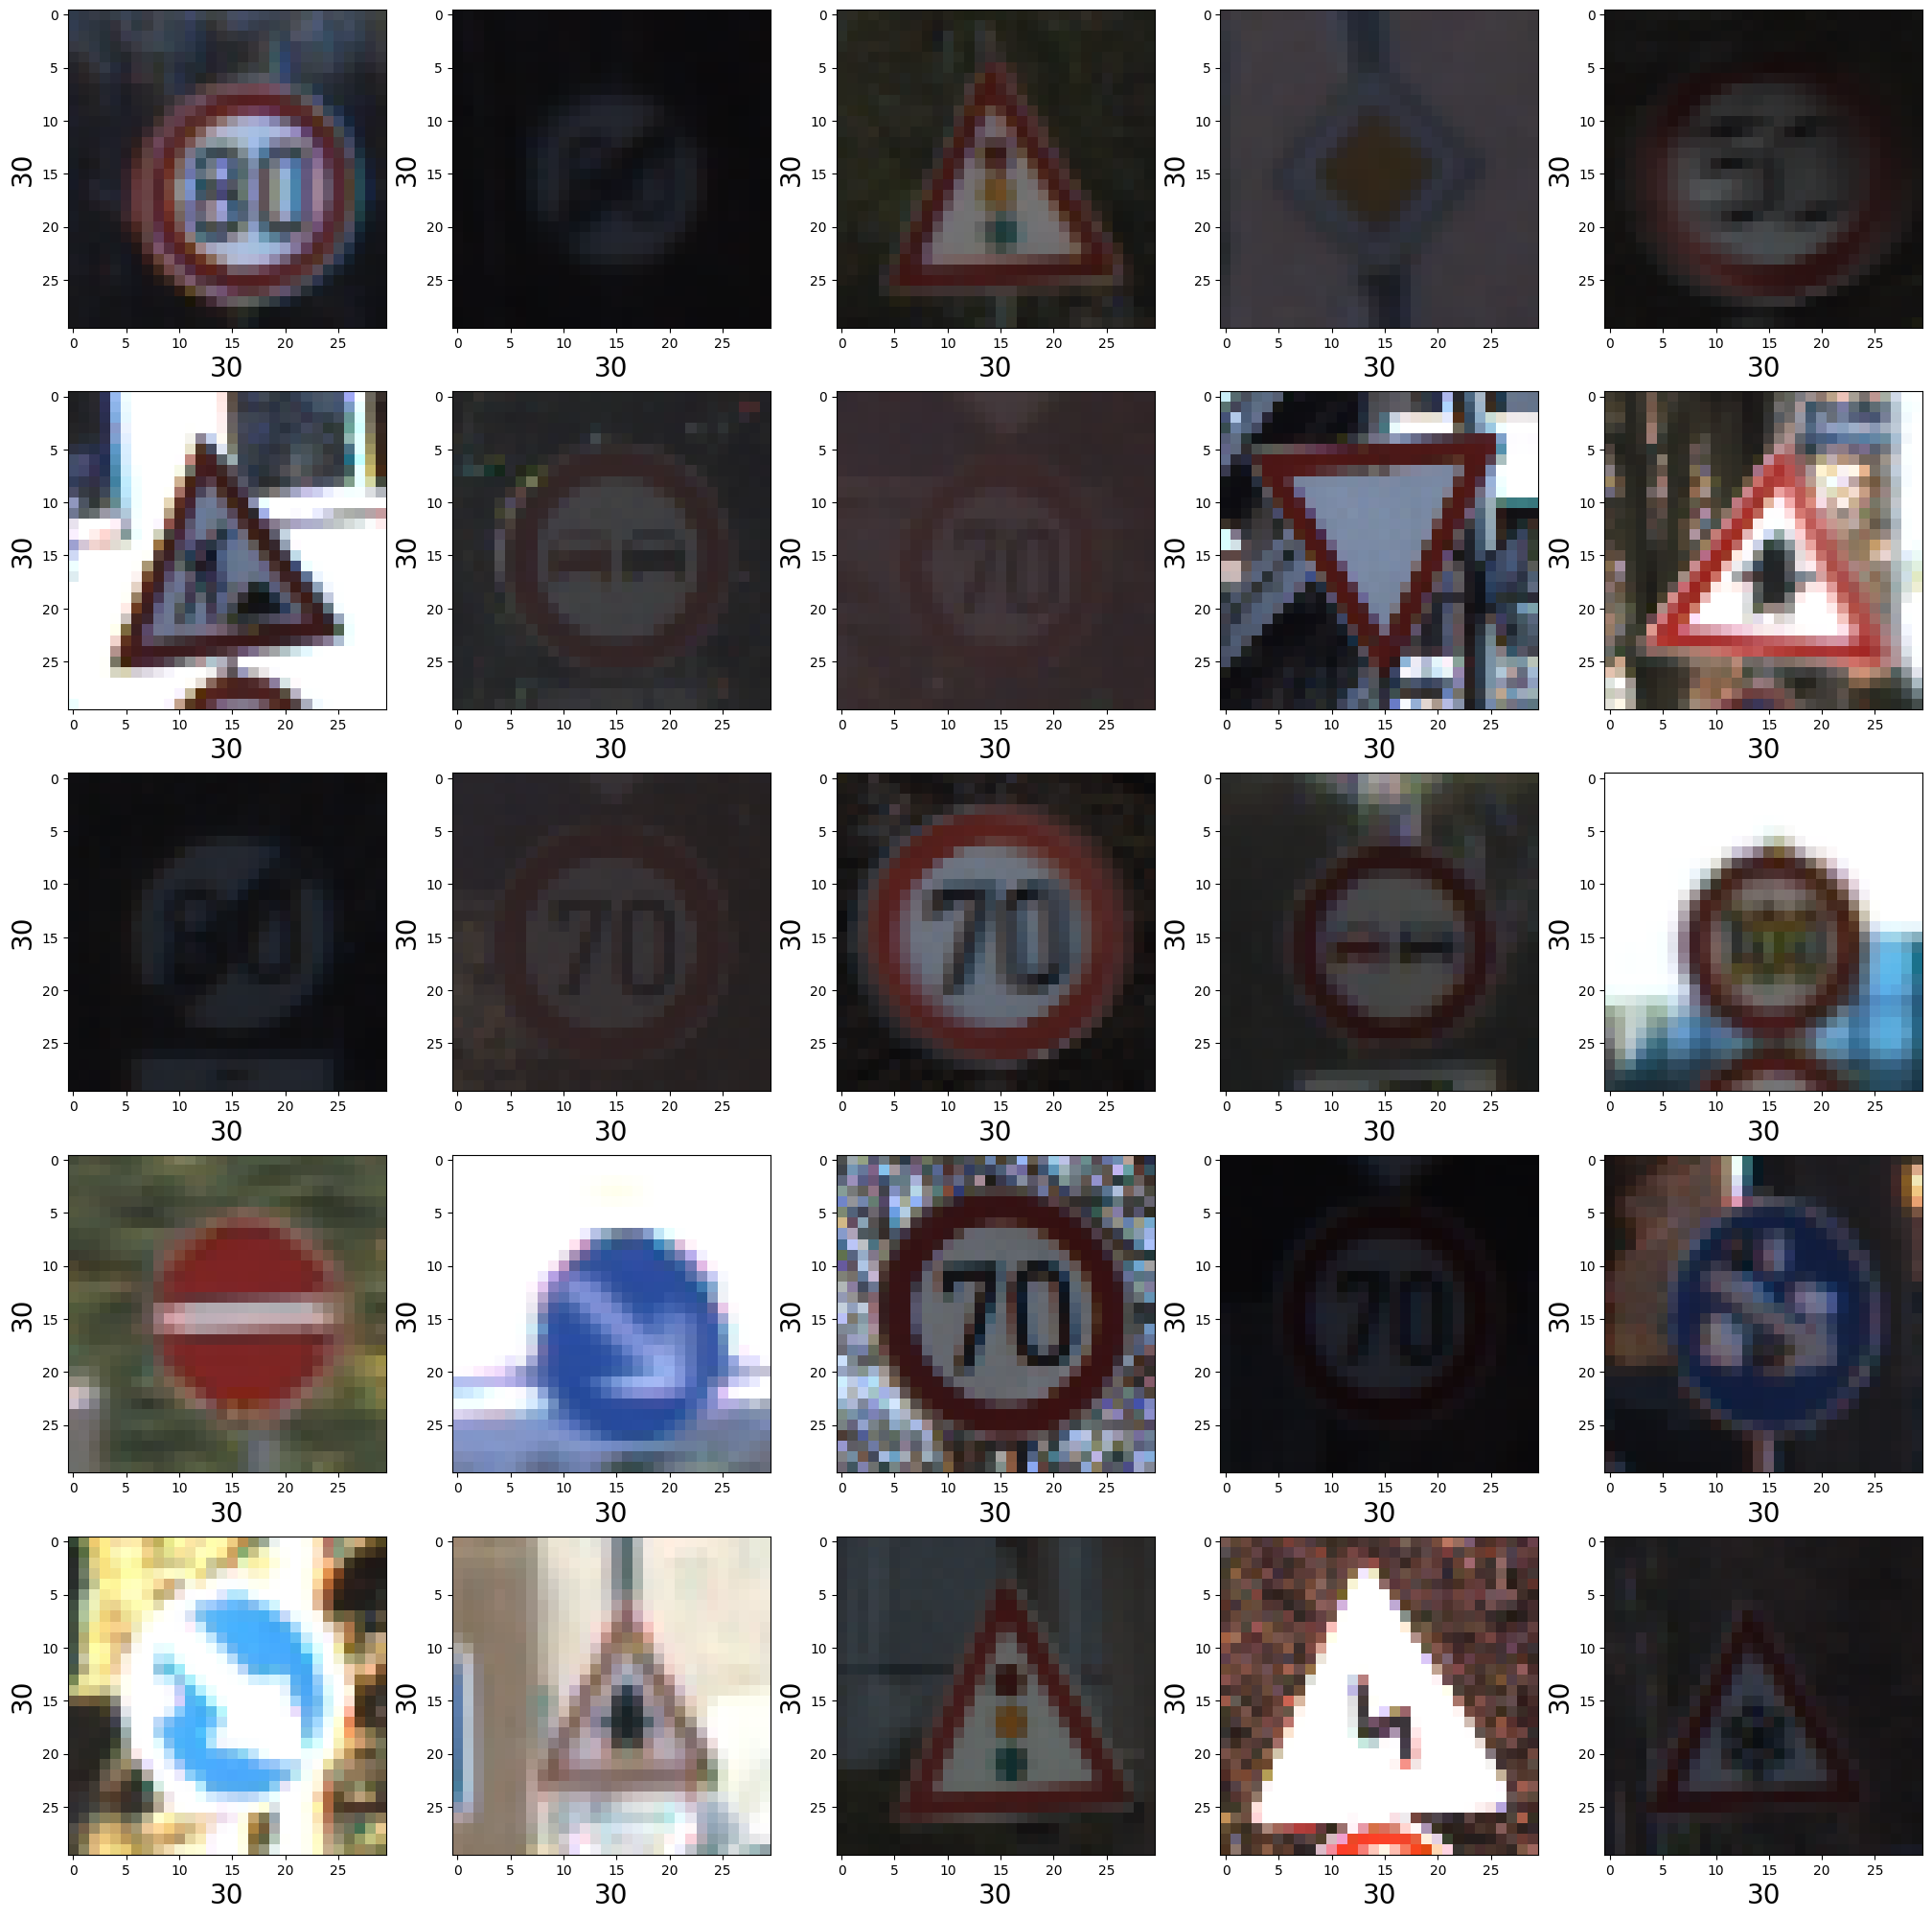

In [71]:
plt.figure(figsize=(25,25))

for i in range(len(images)):
    plt.subplot(5,5,i+1)
    img = images[i].reshape(30,30,3)
    plt.imshow(img)
    plt.xlabel(img.shape[1], fontsize = 20)#width of image
    plt.ylabel(img.shape[0], fontsize = 20)#height of image

In [80]:
print("Acc", accuracy_score(labels,preds))

Acc 0.04


In [81]:
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         0
          32       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [66]:
for key in results.keys():
    if results[key]['Prediction'] == results[key]['True']:
        print(results[key])

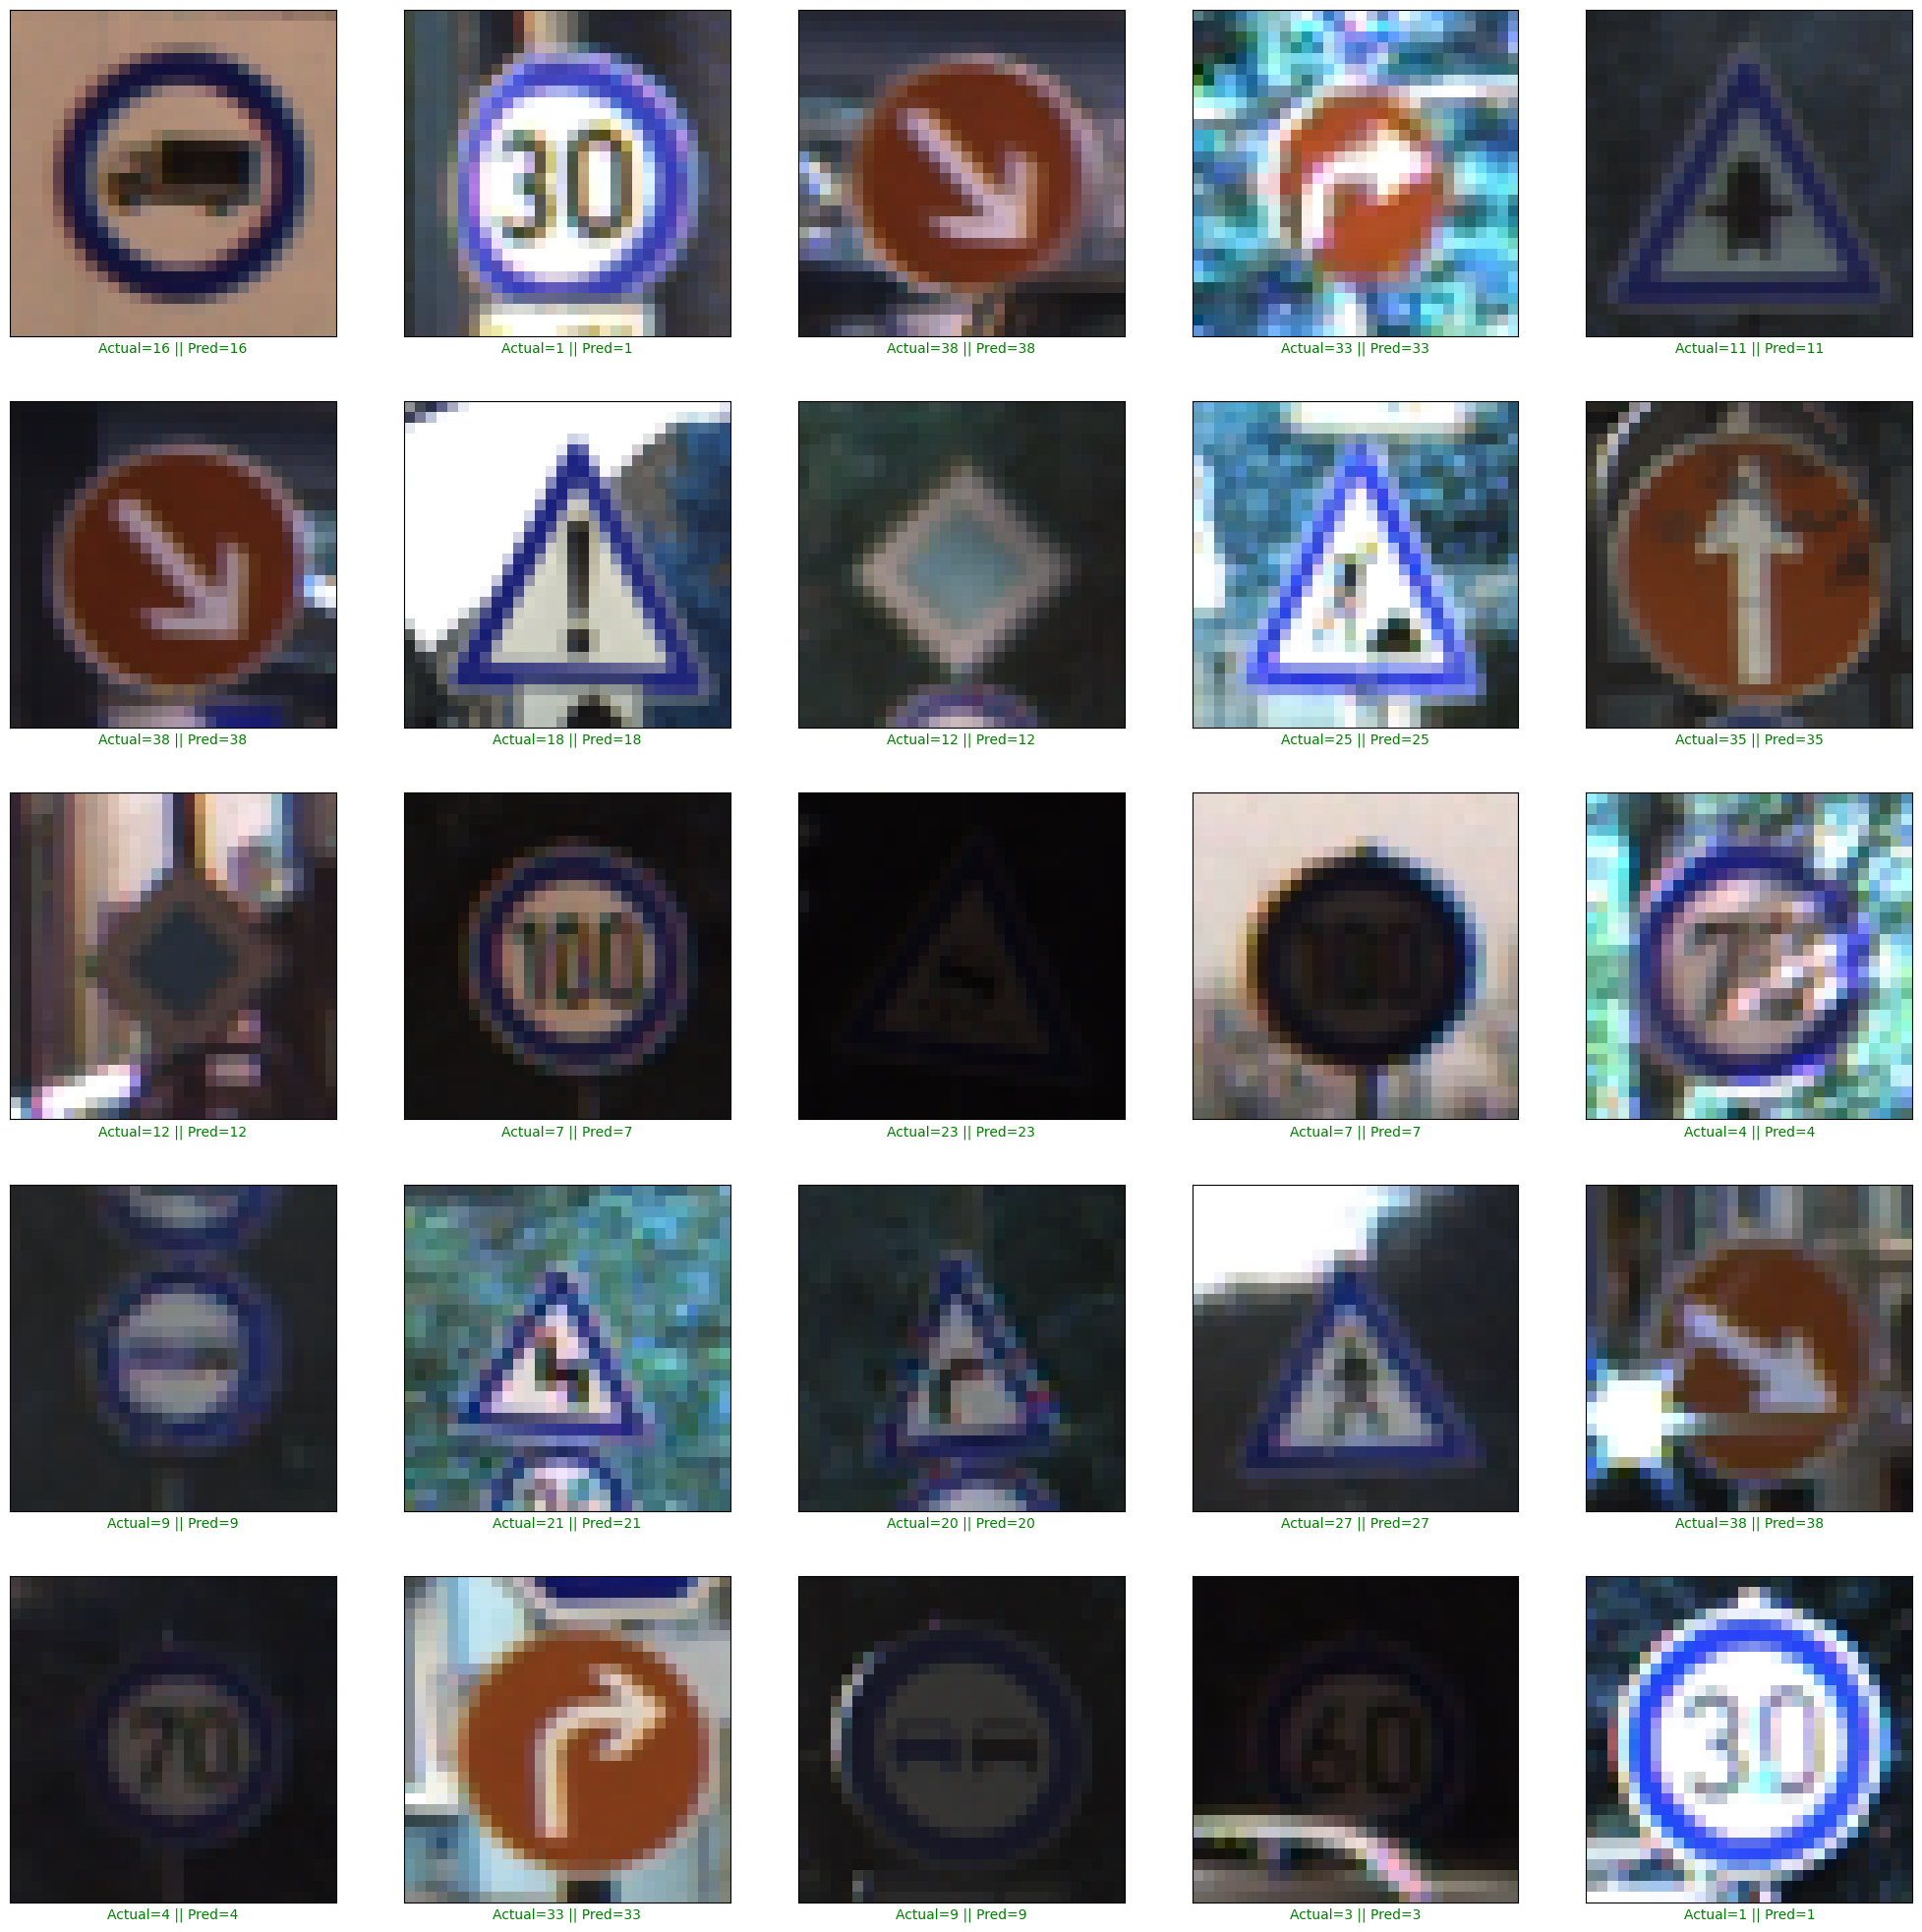

In [104]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()